<h3>В качестве набора данных мы будем использовать набор данных по классификации звезд

<h3> Датасет состоит из 1го файла, который будет необходимо разбить на тренировочную и тестовую выборку. В качестве задачи машинного обучения будет рассматриваться задача определения типа звезды по её параметрам т.е. классификация.

In [2]:
from IPython.display import Image
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score , roc_curve, precision_score , recall_score , plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_wine
from io import StringIO 
%matplotlib inline 
sns.set(style="ticks")

In [3]:
#Считываем датасет из csv файла.
data = pd.read_csv("/home/igor/Downloads/Stars.csv", sep=',')
# Удалим дубликаты записей, если они присутствуют.
data = data.drop_duplicates()

<H2>Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

In [4]:
data.shape

(240, 7)

In [5]:
# Первые 5 строк датасета
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


Temperature -- K

L -- L/Lo

R -- R/Ro

AM -- Mv

Color -- General Color of Spectrum

Spectral_Class -- O,B,A,F,G,K,M / SMASS - https://en.wikipedia.org/wiki/Asteroid_spectral_types

Type -- Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , Super Giants, Hyper Giants

MATH:

Lo = 3.828 x 10^26 Watts

(Avg Luminosity of Sun)

Ro = 6.9551 x 10^8 m

(Avg Radius of Sun)

In [6]:
# Проверим наличие пустых значений
data.isnull().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

Вывод. Представленный набор данных не содержит пропусков.

In [7]:
data.dtypes


Temperature         int64
L                 float64
R                 float64
A_M               float64
Color              object
Spectral_Class     object
Type                int64
dtype: object

In [8]:
cleanup_nums = {"Color":     {"Red": 0, "Blue White": 1,
                              "White": 2,"Yellowish White": 4,
                               "Blue white": 1,
       "Pale yellow orange": 5, "Blue": 6, "Blue-white": 1, "Whitish": 2,
       "yellow-white":4, "Orange": 5, "White-Yellow": 4, "white": 2, "yellowish": 8,
       "Yellowish": 8, "Orange-Red": 0, "Blue-White": 1 },
}
data = data.replace(cleanup_nums)
data=pd.get_dummies(data, columns=["Spectral_Class"], prefix=["Class"])

In [9]:
data.head()


,Temperature,L,R,A_M,Color,Type,Class_A,Class_B,Class_F,Class_G,Class_K,Class_M,Class_O
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,0,1,0


In [10]:
import statsmodels.regression.linear_model as sm
# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X=data.drop(['Type'],axis=1)
np.asarray(X)
calculate_vif(X)

,Var,Vif
11,Class_O,8.47
6,Class_B,4.72
4,Color,4.26
0,Temperature,3.59
10,Class_M,3.07
3,A_M,3.00
1,L,2.62
2,R,2.40
7,Class_F,1.82
5,Class_A,1.43


In [11]:
data = data.drop(['Class_O'],axis=1)
data= data.drop(['Class_B'],axis=1)

In [12]:
X=data.drop(['Type'],axis=1)
calculate_vif(X)

,Var,Vif
4,Color,3.96
0,Temperature,3.57
1,L,3.18
3,A_M,3.15
9,Class_M,2.67
2,R,2.56
6,Class_F,1.25
8,Class_K,1.19
5,Class_A,1.09
7,Class_G,1.04


Вывод мы избавилиьс от мультиколлинеарности и избавились от категориальных признаков.dtype=

<h2>Построение графиков для понимания структуры данных

In [13]:
# Парные диаграммы
#sns.pairplot(data)

In [14]:
# Оценим дисбаланс классов для Type
data['Type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: Type, dtype: int64

<h3>Вывод. Распределение по классам равномерное .


In [15]:
data.dtypes

Temperature      int64
L              float64
R              float64
A_M            float64
Color            int64
Type             int64
Class_A          uint8
Class_F          uint8
Class_G          uint8
Class_K          uint8
Class_M          uint8
dtype: object

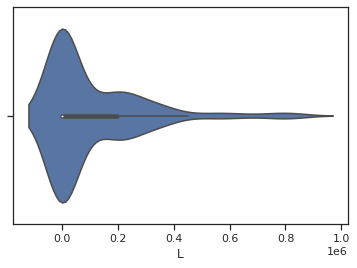

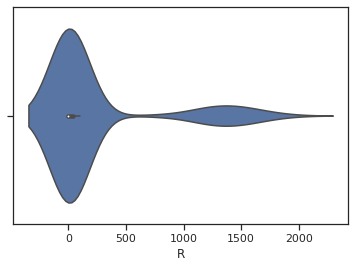

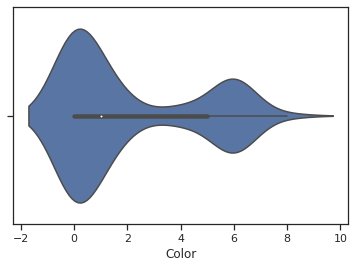

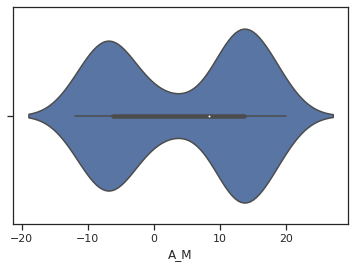

In [16]:
# Скрипичные диаграммы для числовых колонок
for col in ['L', 'R', 'Color', 'A_M']:
    sns.violinplot(x=data[col])
    plt.show()

<H2>Выбор признаков, подходящих для построения моделей. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.</H2>

Выполним масштабирование данных.

In [17]:
# Числовые колонки для масштабирования
data_scaled = data.copy()
scale_cols = ['L', 'R', 'A_M']
sc1 = StandardScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [18]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data_scaled[new_col_name] = sc1_data[:,i]

In [19]:
data_scaled.head()

,Temperature,L,R,A_M,Color,Type,Class_A,Class_F,Class_G,Class_K,Class_M,L_scaled,R_scaled,A_M_scaled
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,1,-0.598624,-0.459210,1.116745
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,1,-0.598624,-0.459241,1.162414
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,1,-0.598624,-0.459342,1.362213
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,1,-0.598624,-0.459229,1.167171
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,1,-0.598624,-0.459340,1.491607


In [20]:
data.head()

,Temperature,L,R,A_M,Color,Type,Class_A,Class_F,Class_G,Class_K,Class_M
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,1
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,1
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,1
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,1
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,1


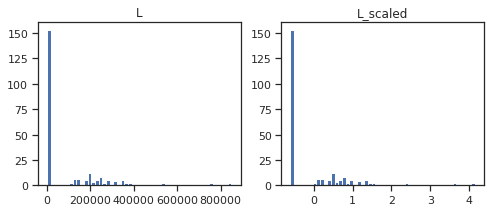

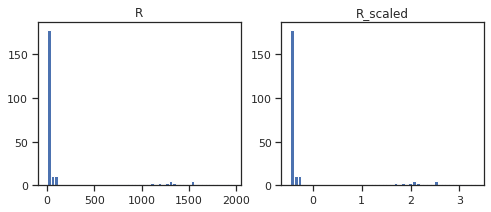

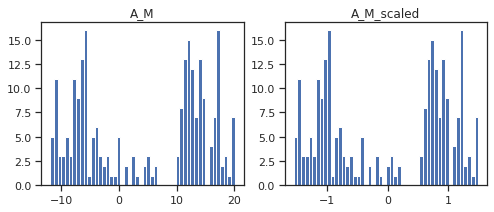

In [21]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data_scaled[col], 50)
    ax[1].hist(data_scaled[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

<h2>Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

In [21]:
data_scaled = data_scaled.drop(scale_cols,axis=1)


In [22]:
data_scaled.head()



,Temperature,Color,Type,Class_A,Class_F,Class_G,Class_K,Class_M,L_scaled,R_scaled,A_M_scaled
0,3068,0,0,0,0,0,0,1,-0.598624,-0.459210,1.116745
1,3042,0,0,0,0,0,0,1,-0.598624,-0.459241,1.162414
2,2600,0,0,0,0,0,0,1,-0.598624,-0.459342,1.362213
3,2800,0,0,0,0,0,0,1,-0.598624,-0.459229,1.167171
4,1939,0,0,0,0,0,0,1,-0.598624,-0.459340,1.491607


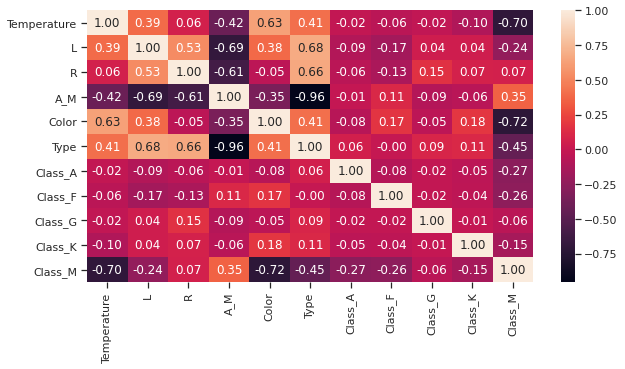

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.show()

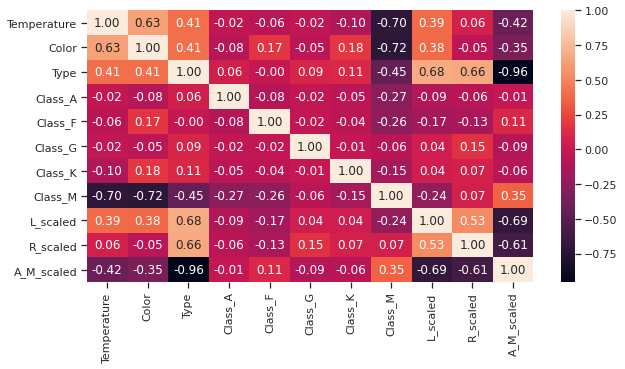

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data_scaled.corr(), annot=True, fmt='.2f')
plt.show()



На основе корреляционной матрицы можно сделать следующие выводы:

-  Корреляционные матрицы для исходных и масштабированных данных совпадают(за исключением поряка строк и столбцов).
-  Целевой признак классификации "Type" наиболее сильно коррелирует с численными параметрами такими как Радиус(R)(0.66), Светимостью(L)(0.68) и A_M (-0.96). Эти признаки обязательно следует оставить в моделирам классификации.
-  Сильнокореллированных признаков нет.
-  Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.



## Выбор метрик для последующей оценки качества моделей.

### В качестве метрик для решения задачи классификации будем использовать следующие метрики:

- precision
- confusion matrix
- accuracy


In [25]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрикеопроб2
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

## Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.

#### Для задачи классификации будем использовать следующие модели:
* Логистическая регрессия
* Метод ближайших соседей
* Метод опорных векторов
* Решающее дерево
* Случайный лес
* Градиентный бустинг

## Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [51]:
data_Y = data.loc[:, 'Type']
data_X = data.drop(["Type"],axis=1,inplace=False)
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(
    data_X, data_Y,test_size=0.6, random_state=360)

data_X_train.shape, data_X_test.shape,data_y_train.shape, data_y_test.shape

((96, 10), (144, 10), (96,), (144,))

### Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

In [52]:
# Модели
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(probability=True),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

In [53]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [54]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(data_X_train, data_y_train)
    # Предсказание значений1
    Y_pred = model.predict(data_X_test)
    
    precision = precision_score(data_y_test, Y_pred,average = 'micro')
    recall = recall_score(data_y_test, Y_pred,average = 'micro')
    f1 = f1_score(data_y_test, Y_pred,average = 'micro')
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    fig, ax = plt.subplots(ncols=1, figsize=(10,5))  
    plot_confusion_matrix(model, data_X_test, data_y_test.values,ax=ax,
                      display_labels=data_Y.unique(), 
                      cmap=plt.cm.Blues)
    fig.suptitle(model_name)
    print('{} \t Precision={}, Recall={}, F1={}'.format(
        model_name, round(precision, 3), round(recall, 3), round(f1, 3)))
    plt.show()

LogR 	 Precision=0.556, Recall=0.556, F1=0.556


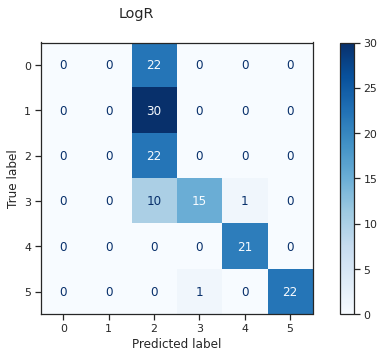

KNN_5 	 Precision=0.59, Recall=0.59, F1=0.59


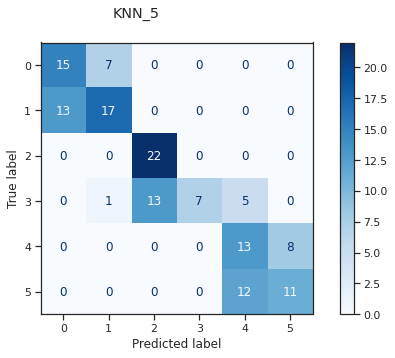

SVC 	 Precision=0.389, Recall=0.389, F1=0.389


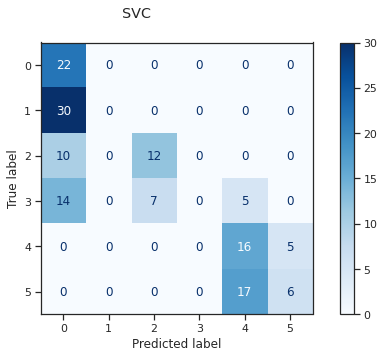

Tree 	 Precision=0.972, Recall=0.972, F1=0.972


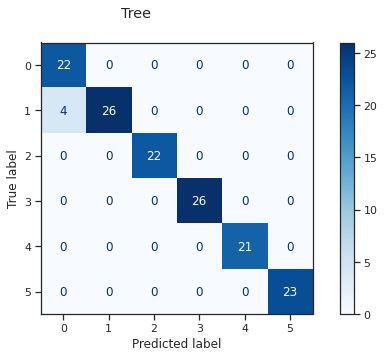

RF 	 Precision=0.965, Recall=0.965, F1=0.965


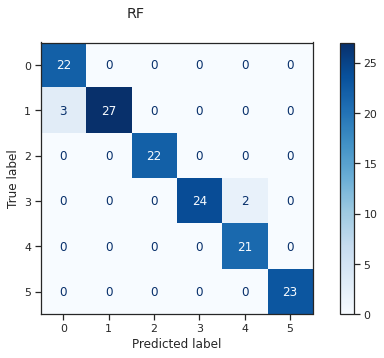

GB 	 Precision=0.91, Recall=0.91, F1=0.91


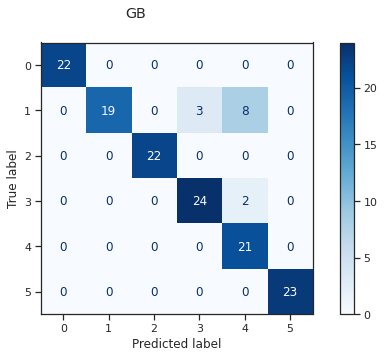

In [55]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

In [56]:
data_Y.unique()

array([0, 1, 2, 3, 4, 5])

## Подбор гиперпараметров для выбранных моделей. 

In [57]:
n_range_list = list(range(1,100,1))
n_range_list[0] = 1

In [58]:
n_range = np.array(n_range_list)
tuned_parameters = {"n_neighbors" : n_range}
tuned_parameters

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}

In [59]:
knn_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='f1_micro')
knn_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='f1_micro')

In [60]:
lr_grid={"C":np.logspace(-2,3,6), "penalty":["l1","l2"], "tol" : np.logspace(-4,-1,4),
                                'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr_gs = GridSearchCV(LogisticRegression(), lr_grid, cv=5, scoring='f1_micro')
lr_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': array([0.0001, 0.001 , 0.01  , 0.1   ])},
             scoring='f1_micro')

In [61]:
SVC_grid=[{'kernel': ['rbf']},
                    {'kernel': ['linear']}]
SVC_gs = GridSearchCV(SVC(), SVC_grid, cv=5, scoring='f1_micro')
SVC_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'kernel': ['rbf']}, {'kernel': ['linear']}],
             scoring='f1_micro')

In [62]:
tree_grid={'max_depth': np.linspace(1,10,10)} 
tree_gs = GridSearchCV(DecisionTreeClassifier(), tree_grid, cv=5, scoring='f1_micro')
tree_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             scoring='f1_micro')

In [63]:
rf_grid={'max_depth': list(range(1,10,1)),'n_estimators': list(range(1,30,2))} 
rf_gs = GridSearchCV(RandomForestClassifier(), rf_grid, cv=5, scoring='f1_micro')
rf_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29]},
             scoring='f1_micro')

In [64]:
gb_gs = GridSearchCV(GradientBoostingClassifier(), rf_grid, cv=5, scoring='f1_micro')
gb_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29]},
             scoring='f1_micro')

Text(0.5, 0.98, 'Tree')

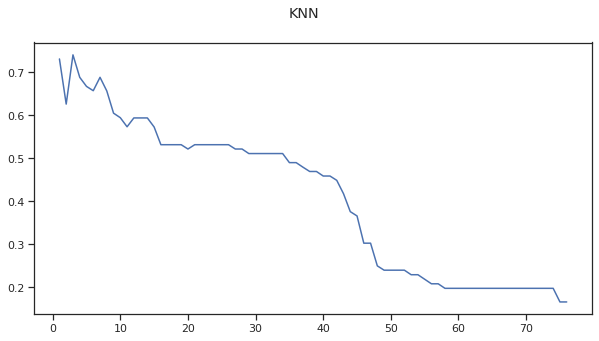

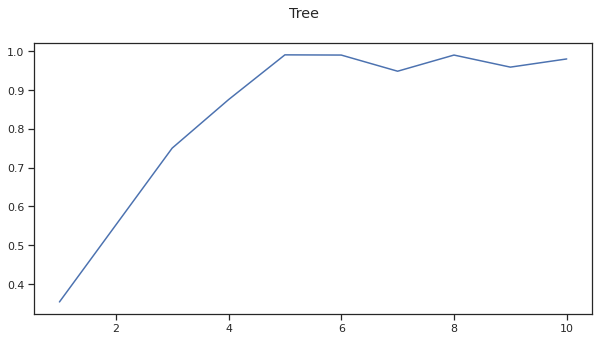

In [65]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
fig, ax = plt.subplots(ncols=1, figsize=(10,5))  
plt.plot(n_range, knn_gs.cv_results_['mean_test_score'])
fig.suptitle('KNN')
fig.show()
fig, ax = plt.subplots(ncols=1, figsize=(10,5))  
plt.plot(np.linspace(1,10,10), tree_gs.cv_results_['mean_test_score'])
fig.suptitle('Tree')

KNN_5 	 Precision=0.59, Recall=0.59, F1=0.59


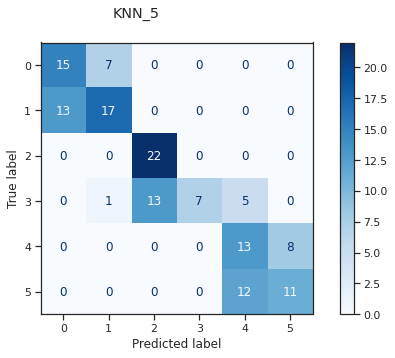

KNN_ {'n_neighbors': 3} 	 Precision=0.59, Recall=0.59, F1=0.59


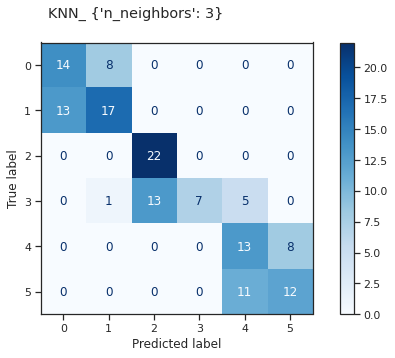

LogR 	 Precision=0.556, Recall=0.556, F1=0.556


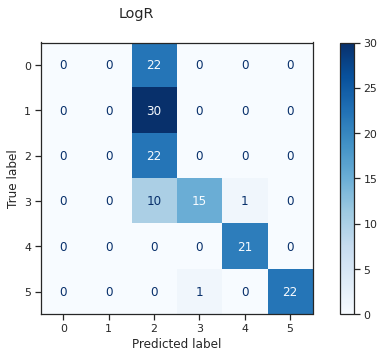

LogR {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001} 	 Precision=0.986, Recall=0.986, F1=0.986


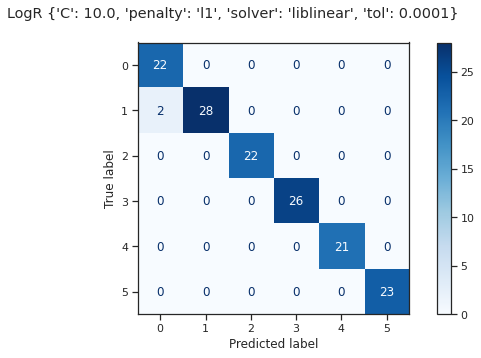

SVC 	 Precision=0.389, Recall=0.389, F1=0.389


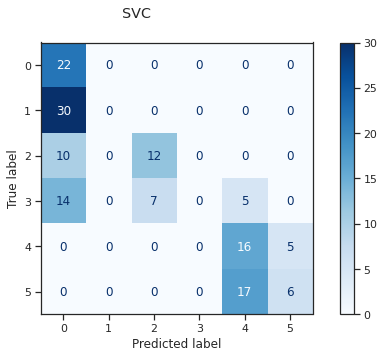

SVC dict_items([('kernel', 'linear')]) 	 Precision=0.965, Recall=0.965, F1=0.965


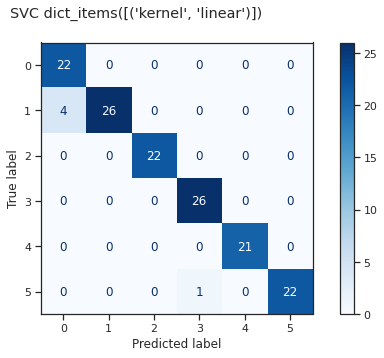

Tree 	 Precision=1.0, Recall=1.0, F1=1.0


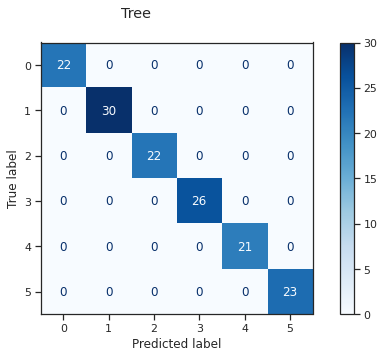

Tree dict_items([('max_depth', 5.0)]) 	 Precision=0.965, Recall=0.965, F1=0.965


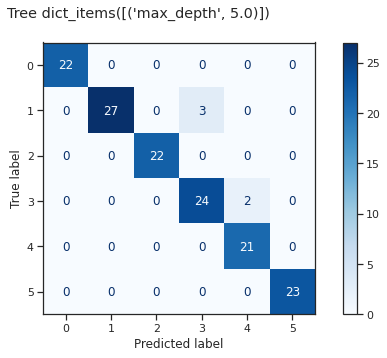

RF 	 Precision=0.965, Recall=0.965, F1=0.965


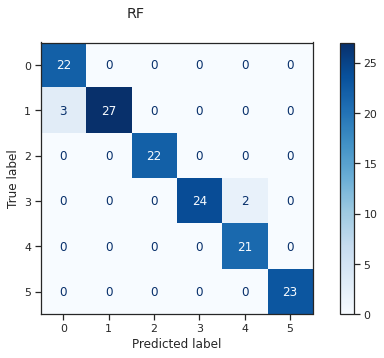

RF dict_items([('max_depth', 3), ('n_estimators', 13)]) 	 Precision=0.958, Recall=0.958, F1=0.958


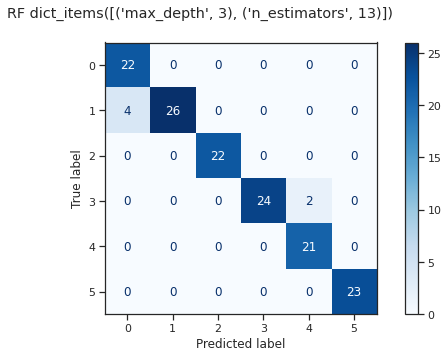

GB 	 Precision=0.91, Recall=0.91, F1=0.91


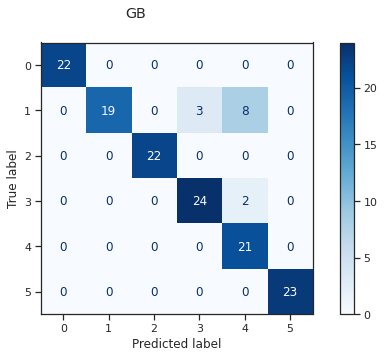

GB dict_items([('max_depth', 2), ('n_estimators', 9)]) 	 Precision=0.965, Recall=0.965, F1=0.965


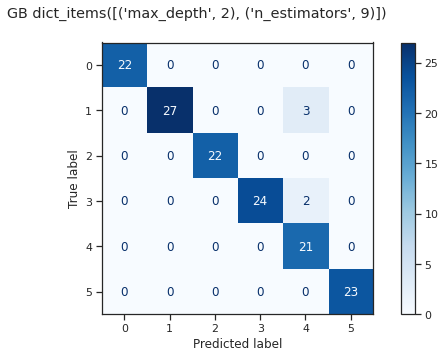

In [66]:
clas_models_grid = {'KNN_5':KNeighborsClassifier(n_neighbors=5), 
                    str('KNN_ ' + str(knn_gs.best_params_)):knn_gs.best_estimator_,
                    'LogR': LogisticRegression(), 
                    str('LogR ' + str(lr_gs.best_params_)):lr_gs.best_estimator_,
                    'SVC':SVC(probability=True),
                    str('SVC ' + str(SVC_gs.best_params_.items())):SVC_gs.best_estimator_,
                    'Tree':DecisionTreeClassifier(),
                    str('Tree '+str(tree_gs.best_params_.items())):tree_gs.best_estimator_,
                    'RF':RandomForestClassifier(),
                    str('RF '+str(rf_gs.best_params_.items())):rf_gs.best_estimator_,
                    'GB':GradientBoostingClassifier(),
                    str('GB '+str(gb_gs.best_params_.items())):gb_gs.best_estimator_}

for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)



In [67]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1'], dtype=object)

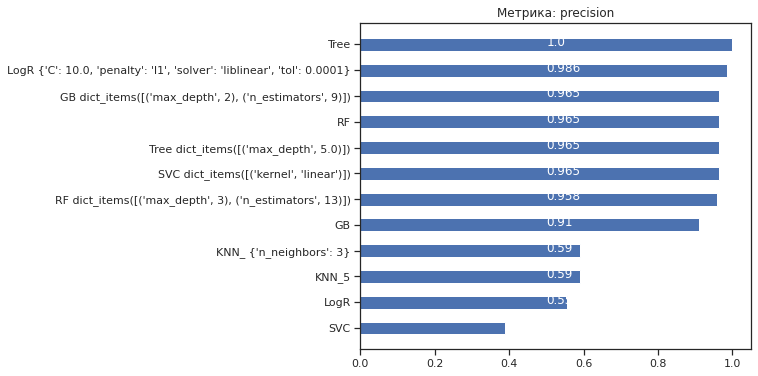

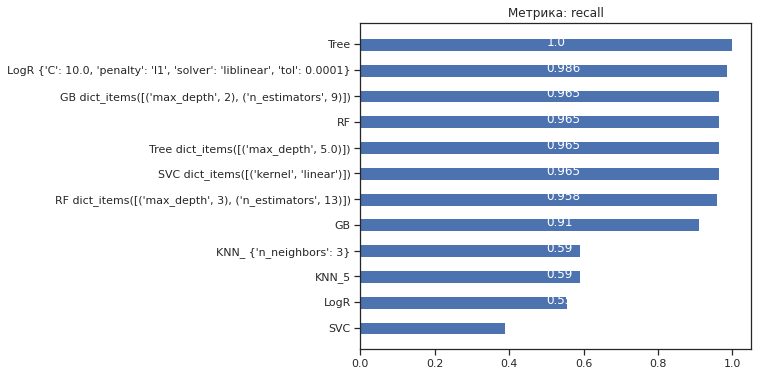

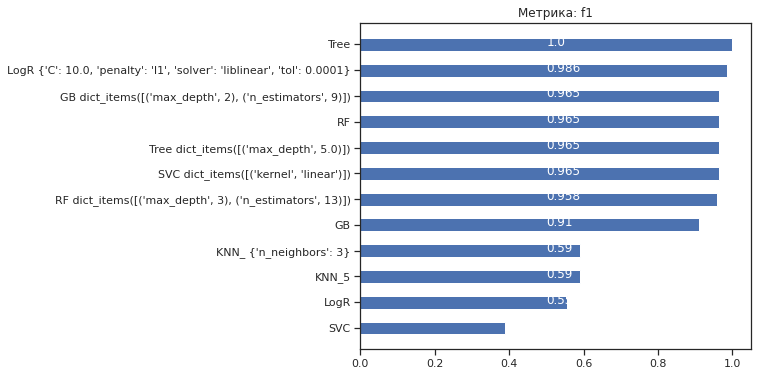

In [68]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

In [69]:
np.logspace(-4,4,9)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])